In [34]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score
from mpl_toolkits.basemap import Basemap
from bayes_opt import BayesianOptimization
import math
import boto3
import os
from os.path import expanduser
import json

%matplotlib inline

In [2]:
def main_program():
    #Define Key Values Here
    SR_minrate = 5 #only keep data with rainrate greater than this value
    opt_frac = .05 #fraction of data to use when determining the optimal dbscan parameters
    Rad_Earth = 6371 #km earth's radius
    MesoScale = 200 #Mesoscale is up to a few hundred km'
    FrontSpeed = 30 # km/h speed at which a front often moves

    Data, Time, A = load_s3_data(SR_minrate)
    DeltaTime = time_to_deltaTime(Time)
    
    Data = np.concatenate((DeltaTime.reshape(len(DeltaTime),1), Data), axis=1)
    Data = np.squeeze(Data)
    
    DatatoCluster = data_to_cluster(Data)
    
    Distance = create_distance_matrix(DatatoCluster,FrontSpeed,Rad_Earth)
    
    eps, minSamples = optimal_params(Distance[0:int(len(DatatoCluster)*opt_frac),0:int(len(DatatoCluster)*opt_frac)])
    
    labels = cluster_and_label_data(Distance,eps,minSamples)
    
    #Want to save this output but not sure what the best format is


In [53]:
#function that connects to the S3 bucket, downloads the file, reads in the data, and deletes the file
def load_s3_data(SR_minrate):
    #create empty matrices to hold the extracted data
    Lat_Heat = []
    surf_r = []
    LAT = []
    LON = []
    TIME = []
    count = 0
    
    home = expanduser("~")

    with open(os.path.join(home,'creds.json')) as creds_file:
        creds_data = json.load(creds_file)

    #Access from S3
    s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
             aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
    bucket = s3.Bucket('himatdata')
    home = os.getcwd()

    for obj in bucket.objects.filter(Delimiter='', Prefix='Trmm/EPO/2000_01'):
        bucket.download_file(obj.key,os.path.join(os.path.join(home,'S3_downloads/',obj.key[17:])))
        print(obj.key[17:])

    #file = 'oneProfile/TPR7_uw1_00538.19980101.000558_EPO.nc4'
        L, S, A, la, lo, Ti = extract_data(xr.open_dataset(os.path.join(home,'S3_downloads/',obj.key[17:])),SR_minrate)
       #append the new data in the matrices
        if count==0:
            Lat_Heat = L
            LAT = la[:,0]
            LON = lo[:,0]
            TIME = Ti
            count += 1
        else:
            Lat_Heat = np.concatenate((Lat_Heat,L),axis =0)
            LAT = np.concatenate((LAT,la[:,0]),axis =0)
            LON = np.concatenate((LON,lo[:,0]),axis =0)
            TIME = np.concatenate((TIME,Ti),axis =0)
        surf_r = np.append(surf_r,S)
        
        #delete the local file
        os.remove(os.path.join(home,'S3_downloads/',obj.key[17:]))
        

    #Put all the data into one array, where rows are individual observations and the columns are 
    #[Latitude, Longitude, Surface Rain, Latent Heat Profile]
    Data = np.concatenate((LAT.reshape(len(LAT),1),LON.reshape(len(LON),1),surf_r.reshape(len(surf_r),1),Lat_Heat),axis=1)
    Data = np.squeeze(Data)
    
    #Remove repeated values
    uniqueData = np.unique(Data,axis=0)
    
    return uniqueData, TIME, A
    

In [4]:
#Translate the time into delta time since the first datapoint (in hours)
def time_to_deltaTime(Time):
    InitialTime = np.min(Time)
    DeltaTime = []
    DeltaTime[:] = [int(x-InitialTime)/(10**9*60*60) for x in Time] #from nanoseconds to hours
    DeltaTime = np.array(DeltaTime) #convert from list to array
    
    return DeltaTime

In [5]:
#Create array to Cluster the rainfall events, Scale the grid lat/lon so it is weighted 'fairly' compared to time
def data_to_cluster(Data):
    #Extract [Lat, Lon, DeltaTime]
    Xdata = np.vstack((Data[:,1],Data[:,2],Data[:,0]))
    Xdata = Xdata.T
    return Xdata

In [6]:
def cluster_and_label_data(Distance,eps,min_samps):
    model = DBSCAN(eps=eps, min_samples=min_samps,metric='precomputed')
    model.fit(Distance)

    labels = model.labels_
    
    return labels

In [7]:
#Use Bayesian Optimization on the data to get the best parameters for the clustering
def optimal_params(Data):
    Opt = optimize_dbscan(Data,'davies') #it seems like silhouette takes substantially longer?
    min_samps = int(Opt['params']['min_samp'])
    eps = Opt['params']['EPS']

    return eps, min_samps

In [8]:
#function that fits dbscan for given parameters and returns the davies bouldin score evaluation metric 
def dbscan_eval_db(eps,min_samples,data):
    model = DBSCAN(eps=eps, min_samples=min_samples,metric='precomputed')
    model.fit(data)
    labels = model.labels_
    if len(set(labels))<2:
        score = 0
    else:
        score = davies_bouldin_score(data, labels)
        
    return score

In [9]:
#function that fits dbscan for given parameters and returns the silhouette score evaluation metric 
def dbscan_eval_sil(eps,min_samples,data):
    model = DBSCAN(eps=eps, min_samples=min_samples,metric='precomputed')
    model.fit(data)
    labels = model.labels_
    if len(set(labels))<2:
        score = 0
    else:
        score = metrics.silhouette_score(data,labels)
        
    return score

In [19]:
#Applies bayesian optimization to determine DBSCAN parameters that maximize the evaluation metric (specified as input)
def optimize_dbscan(data,metric='silhouette'):
    """Apply Bayesian Optimization to DBSCAN parameters."""
    def dbscan_evaluation_sil(EPS, min_samp):
        """Wrapper of DBSCAN evaluation."""
        min_samp = int(min_samp) #insure that you are using an integer value for the minimum samples parameter
        return dbscan_eval_sil(eps=EPS, min_samples=min_samp, data=data)

    def dbscan_evaluation_db(EPS, min_samp):
        """Wrapper of DBSCAN evaluation."""
        min_samp = int(min_samp) #insure that you are using an integer value for the minimum samples parameter
        return dbscan_eval_db(eps=EPS, min_samples=min_samp, data=data)

    if metric == 'davies':
        optimizer = BayesianOptimization(
            f=dbscan_evaluation_db,
            pbounds={"EPS": (100, 600), "min_samp": (5, 30)}, #bounds on my parameters - these are very rough guesses right now
            random_state=1234,
            verbose=2
        )
        
    else:
        optimizer = BayesianOptimization(
            f=dbscan_evaluation_sil,
            pbounds={"EPS": (100, 600), "min_samp": (5, 30)}, #bounds on my parameters - these are very rough guesses right now
            random_state=1234,
            verbose=2
        )
    
    optimizer.maximize(n_iter=10)

    #print("Final result:", optimizer.max)
    return optimizer.max

In [11]:
#This function takes in a file name (downloaded from trmm.atmos.washington.edu) and extracts the variables
#that I care about (latitude, longitude, altitude, surface rain, latent heat). It does the inital data checks and
#throws out profiles with missing information or minimal rainfall. It returns the variables I care about that pass these
#checks

def extract_data(file, SR_min=5):
    #Extract the data you want from file
    altitude_lh = file.altitude_lh.data
    surf_rain = file.surf_rain.data
    latent_heating = file.latent_heating.data

    lat = file.latitude.data
    lon = file.longitude.data
    time = file.time.data
    
    #create grid of altitude, lat, and lon coordinates
    LAT, ALTITUDE, LON = np.meshgrid(lat, altitude_lh, lon)

    #size of lat and lon as variables
    nlat = len(lat)
    nlon = len(lon)
    nalt = len(altitude_lh)

    #reshape as column vector (note the indicing is now column*ncolumns+row)
    surf_rain = np.reshape(surf_rain,[nlat*nlon])
    LH = np.reshape(latent_heating,[nalt,nlat*nlon])
    ALTITUDE = np.reshape (ALTITUDE,[nalt,nlat*nlon])
    LON = np.reshape (LON,[nalt,nlat*nlon])
    LAT = np.reshape (LAT,[nalt,nlat*nlon])

    #Remove values with NaN and rainfall less than cut-off
    surf_R = surf_rain[~np.isnan(surf_rain)]
    surf_r = surf_R[surf_R>=SR_min]

    Lat_Heat = LH[:,~np.isnan(surf_rain)]
    Lat_Heat = Lat_Heat[:,surf_R>=SR_min]
    Lat_Heat = np.squeeze(Lat_Heat)

    ALTITUDE = ALTITUDE[:,~np.isnan(surf_rain)]
    ALTITUDE = ALTITUDE[:,surf_R>=SR_min]
    ALTITUDE = np.squeeze(ALTITUDE)

    LAT = LAT[:,~np.isnan(surf_rain)]
    LAT = LAT[:,surf_R>=SR_min]
    LAT = np.squeeze(LAT)

    LON = LON[:,~np.isnan(surf_rain)]
    LON = LON[:,surf_R>=SR_min]
    LON = np.squeeze(LON)

    #Remove any profiles where there is missing latent heat info
    surf_r = surf_r[~pd.isnull(Lat_Heat).any(axis=0)]
    LAT = LAT[:,~pd.isnull(Lat_Heat).any(axis=0)]
    LON = LON[:,~pd.isnull(Lat_Heat).any(axis=0)]
    ALTITUDE = ALTITUDE[:,~pd.isnull(Lat_Heat).any(axis=0)]
    Lat_Heat = Lat_Heat[:,~pd.isnull(Lat_Heat).any(axis=0)]
    Time = np.repeat(time,len(surf_r))
    
    return Lat_Heat.T, surf_r.T, ALTITUDE.T, LAT.T, LON.T, Time.T

In [12]:
#calcuate the distance (in degrees) between 2 points in lat/long
def lat_long_to_arc(lat1,long1,lat2,long2):
    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    if cos>1: cos=1
    if cos<-1: cos=-1
    arc = math.acos( cos )

    return arc

In [13]:
def create_distance_matrix(Data,FrontSpeed,Rad_Earth):
    Scale_Time_to_Distance = FrontSpeed

    Distance = np.zeros((len(Data),len(Data)))
    for i in range(len(Data)):
        for j in range(i,len(Data)):
            d = Rad_Earth*lat_long_to_arc(Data[i,0],Data[i,1],Data[j,0],Data[j,1])
            D = math.sqrt(d**2+(Scale_Time_to_Distance*(Data[i,2]-Data[j,2]))**2)
            Distance[i,j] = D
            Distance[j,i] = D
    return Distance

In [ ]:
#Old code that was used originally to loop through the files in the EPO (eastern Pacific Ocean) for 2018 that I had 
#downloaded to my local machine and repackage observations with rain into monthly files. Those files were then saved
#to my local machine

#for each month, extract the rain events that happen during that month and save it as a new netcdf file
#months = ['01','02','03','04','05','06','07','08','09','10','11','12']
#for m in range(len(months)):
#   #create empty matrices to hold the extracted data
#    Lat_Heat = []
#    surf_r = []
#    ALTITUDE = []
#    LAT = []
#    LON = []
#    TIME = []
#    count = 0
#
#   #loop through each file in the given month folder
#    for file in glob.glob("/Users/Lauren/Documents/NOAA/Precipitation/**/"+months[m]+"/*.nc4", recursive=True):
#        #extract the relevant data I wish to keep
#        L, S, A, la, lo, Ti = extract_data(xr.open_dataset(file))
#       #append the new data in the matrices
#        if count==0:
#            Lat_Heat = L
#            ALTITUDE = A
#            LAT = la
#            LON = lo
#            TIME = Ti
#            count += 1
#        else:
#            Lat_Heat = np.concatenate((Lat_Heat,L),axis =0)
#            ALTITUDE = np.concatenate((ALTITUDE,A),axis =0)
#            LAT = np.concatenate((LAT,la),axis =0)
#            LON = np.concatenate((LON,lo),axis =0)
#            TIME = np.concatenate((TIME,Ti),axis =0)
#        surf_r = np.append(surf_r,S)
# 
#    #package the matrices as a dataset to save as a netcdf
#    data_in_month = xr.Dataset(
#        data_vars = {'Latitude': (('time', 'altitude'),LAT), 
#                     'Longitude': (('time', 'altitude'),LON), 
#                     'Latent_Heat': (('time', 'altitude'), Lat_Heat),
#                     'surface_rain': (('time'), surf_r)},
#        coords = {'time': TIME,
#                 'altitude': ALTITUDE[0,:]})
#
#    #save as a netcdf
#    data_in_month.to_netcdf(path = "EPO_1998_"+months[m]+".nc4", compute = True)


In [37]:
del Data

SR_minrate = 5 #only keep data with rainrate greater than this value
opt_frac = .05 #fraction of data to use when determining the optimal dbscan parameters
Rad_Earth = 6371 #km earth's radius
MesoScale = 200 #Mesoscale is up to a few hundred km'
FrontSpeed = 30 # km/h speed at which a front often moves

Data, Time, A = load_s3_data(SR_minrate)

DeltaTime = time_to_deltaTime(Time)
print(np.shape(DeltaTime))
Data = np.concatenate((DeltaTime.reshape(len(DeltaTime),1), Data), axis=1)
print(np.shape(Data))

Data = np.squeeze(Data)
print(np.shape(Data))

    
DatatoCluster = data_to_cluster(Data)

Distance = create_distance_matrix(DatatoCluster,FrontSpeed,Rad_Earth)

eps, minSamples = optimal_params(Distance[0:int(len(DatatoCluster)*opt_frac),0:int(len(DatatoCluster)*opt_frac)])
    
labels = cluster_and_label_data(Distance,eps,minSamples)


(225,)
(225, 23)
(225, 23)


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by 

In [38]:
print(labels)

[-1  0  0  0  0  0  0 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  2  1 -1  2  2  2  3  3  4  2  2  2  2 -1  5  3
  3  4  4  2  2  2  5  3  3  3  4  2  2  2  2  5  5  3  3  3  3  3  3  3
  4  4  4  2  2  2  2  2  5  6  6  6  6  3  3  3  3 -1  3  3  3 -1  7  7
  7  7  7 -1 -1  7  7  7  7 -1 -1 -1 -1 -1 -1  8  8  8 -1 -1  8  8  8 -1
  8 -1  9  9 -1  9 -1  9  9  9 -1  9  9  9  9  9  9 -1  9  9  9  9  9 10
  9  9  9  9  9  9  9  9  9  9 10 10 10  9  9  9  9  9  9  9  9  9 10  9
  9  9  9  9  9  9 -1  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9 -1  9  9  9  9  9  9  9  9  9  9 -1 11 -1 -1 -1 11 11 11 11 -1
 11 -1 -1 -1 -1 -1 -1 -1 -1]


In [14]:
#Load in the data from my local machine (now in the monthly compiled files)

#Create empty matrices
LH = []
SR = []
Longitude = []
Latitude = []
Time = []
count = 1
#for each file in the folder, extract and compile the profiles
for file in glob.glob("*.nc4"):
    ds = xr.open_dataset(file)
    if count==1: 
        LH = ds.Latent_Heat.data
        count +=1
    else:
        LH = np.concatenate((LH,ds.Latent_Heat.data),axis=0)
    SR = np.append(SR,ds.surface_rain.data)
    Latitude = np.append(Latitude,ds.Latitude.data[:,1])
    Longitude = np.append(Longitude,ds.Longitude.data[:,1])
    Time.extend(ds.time.data) #I'm not sure I'm treating the time component properly

In [15]:
#Translate the time into delta time since the first datapoint (in hours)
InitialTime = np.min(Time)
DeltaTime = []
DeltaTime[:] = [int(x-InitialTime)/(10**9*60*60) for x in Time] #from nanoseconds to hours
DeltaTime = np.array(DeltaTime) #convert from list to array

In [16]:

#Combine the time, latitude, longitude, and rain rate together for training data to cluster rain events
#Note - I've scaled the time to be 4 hours = 1 to make sure the clustering is weighted properly along the different dimensions
#this can still be tuned futher
#Xdata = np.concatenate((Latitude.reshape(len(Latitude),1),Longitude.reshape(len(Longitude),1),DeltaTime.reshape(len(DeltaTime),1),SR.reshape(len(SR),1)),axis=1)
Xdata = np.concatenate((Latitude.reshape(len(Latitude),1),Longitude.reshape(len(Longitude),1),DeltaTime.reshape(len(DeltaTime),1)),axis=1)
Xdata = Xdata[np.where(SR>5),:] #Only look at rain events greater than 5 mm/hour - need to confirm units!
Xdata = np.squeeze(Xdata)


In [20]:
opt_frac = 1 #fraction of data to use when determining the optimal dbscan parameters
Rad_Earth = 6371 #km earth's radius
MesoScale = 200 #Mesoscale is up to a few hundred km'
FrontSpeed = 30 # km/h speed at which a front often moves

#Distance = create_distance_matrix(Xdata[0:10000,:],FrontSpeed,Rad_Earth)

eps, minSamples = optimal_params(Distance[0:int(len(Distance)*opt_frac),0:int(len(Distance)*opt_frac)])

|   iter    |  target   |    EPS    | min_samp  |
-------------------------------------------------


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  1        |  1.042    |  195.8    |  20.55    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  2        |  1.115    |  318.9    |  24.63    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  3        |  1.234    |  490.0    |  11.81    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  4        |  1.064    |  238.2    |  25.05    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  5        |  1.164    |  579.1    |  26.9     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  6        |  1.211    |  600.0    |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  7        |  1.16     |  518.9    |  5.023    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  8        |  1.049    |  100.0    |  30.0     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  9        |  1.148    |  420.8    |  30.0     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  10       |  1.205    |  412.5    |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  11       |  1.06     |  100.0    |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  12       |  1.237    |  458.9    |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  13       |  1.24     |  289.7    |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  14       |  1.175    |  482.9    |  30.0     |
|  15       |  1.198    |  600.0    |  30.0     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [21]:
labels = cluster_and_label_data(Distance[0:500000,0:500000],eps,minSamples)

In [189]:
#cluster the rain events with dbscan
#use bayesian optimization to find the best parameters
Opt = optimize_dbscan(Xdata[0:20000,:],'davies') #it seems like silhouette takes substantially longer?
min_samps = int(Opt['params']['min_samp'])
eps = Opt['params']['EPS']

#fit the model with the 'best' parameters
model = DBSCAN(eps=eps, min_samples=min_samps)
model.fit(Xdata[0:500000,:])

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
print('Done')

#plot the data clustered together
test = Xdata[0:500000,:] 


|   iter    |  target   |    EPS    | min_samp  |
-------------------------------------------------


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  1        |  1.295    |  8.149    |  20.55    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  2        |  1.299    |  9.626    |  24.63    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  3        |  1.389    |  11.68    |  11.81    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  4        |  1.313    |  8.659    |  25.05    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  5        |  1.339    |  12.75    |  26.9     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  6        |  1.304    |  7.0      |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  7        |  1.316    |  13.0     |  5.0      |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  8        |  1.332    |  7.0      |  30.0     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  9        |  1.319    |  7.0      |  11.63    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  10       |  1.376    |  13.0     |  30.0     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  11       |  1.465    |  13.0     |  14.77    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  12       |  1.37     |  13.0     |  17.23    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  13       |  1.414    |  13.0     |  11.87    |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  14       |  1.345    |  10.21    |  15.1     |


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


|  15       |  1.437    |  13.0     |  13.84    |
Final result: {'target': 1.465110481155558, 'params': {'EPS': 13.0, 'min_samp': 14.774703011985011}}
1237
Done


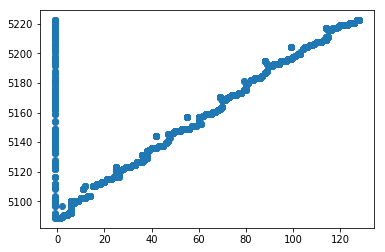

In [23]:
test = Xdata[0:10000,:]

#Look at the time ranges overwhich each cluster extends to see if the time metric is scaled properly
plt.scatter(labels,test[:,2])

(array([105.,   1.,   0.,   2.,   0.,   9.,   0.,   2.,   1.,   9.]),
 array([0.        , 0.81266667, 1.62533333, 2.438     , 3.25066667,
        4.06333333, 4.876     , 5.68866667, 6.50133333, 7.314     ,
        8.12666667]),
 <a list of 10 Patch objects>)

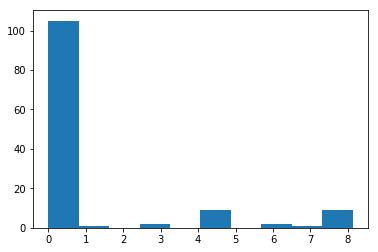

In [26]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
cluster_spans = np.zeros((3,n_clusters_))
for i in range(n_clusters_):
    cluster = test[labels==i,:]
    cluster_spans[:,i] = np.amax(cluster,axis=0)-np.amin(cluster,axis=0)
    
#plt.hist2d(cluster_spans[0,:]/2,cluster_spans[1,:]/2)
plt.hist(cluster_spans[2,:])

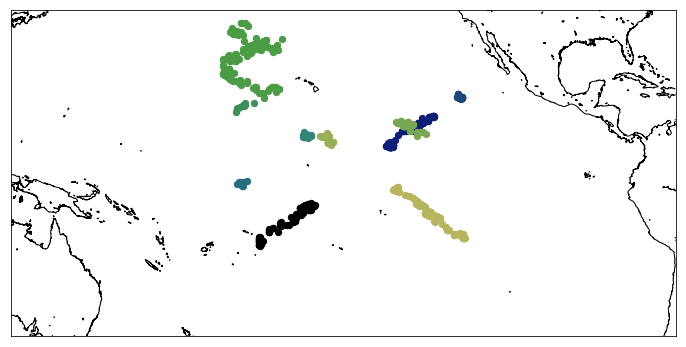

In [30]:
#region overwhich to show the plot
bbox = [np.min(Latitude),np.max(Latitude),
        np.min(Longitude)-50,np.max(Longitude)+50]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()

#look at the clusters within the range labels_min to labels_max
labels_min = np.min(labels)+1
labels_max = 10

#plot the location of rain for the individual clusters (colored by cluster)
for ii in range(labels_min,labels_max):
    cluster = test[labels==ii]
    x,y = m(cluster[:,1],cluster[:,0])
    color_interp = np.interp(ii,[labels_min,labels_max],[0,200])
    plt.scatter(x,y,40,marker='o',color=cmap(int(color_interp)))



In [15]:
#Initial playing around with ML clustering by profiles of heating and rain rate

#combine the latent heat and rain rate at surface together for training data
Xdata = np.concatenate((LH,SR.reshape(len(SR),1)),axis = 1)
Xdata = Xdata[np.where(SR>5),:]
Xdata = np.squeeze(Xdata)

#normalize the data to a zero to one scale
MIN = np.min(Xdata,axis=0)
MAX = np.max(Xdata,axis=0)
np.seterr(divide='ignore', invalid='ignore')
Xdata_scaled = np.subtract(Xdata,MIN)
Xdata_scaled = np.divide(Xdata_scaled,MAX-MIN)
#Xdata_scaled[np.isnan(Xdata_scaled)] = 0

In [18]:
#Playing around with fitting a dbscan on the profiles of LH and surface rain
model = DBSCAN(eps=.05, min_samples=100)
model.fit(Xdata_scaled[0:10000,:])

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
print('Done')


1
Done


(568, 20)
(9432, 20)


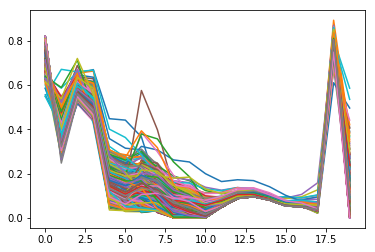

In [19]:
#plot the data clustered together
test = Xdata_scaled[0:10000,:] 

#size of clusters
print(test[labels==-1,:].shape)
print(test[labels==0,:].shape)

plt.plot(test[labels==-1,:].T)


In [196]:
TT = test[labels==6,:]
print(np.amax(TT,axis=0))
print(np.amin(TT,axis=0))

print(cluster_spans[:,6])

TT = test[labels==5,:]
print(np.amax(TT,axis=0))
print(np.amin(TT,axis=0))

print(cluster_spans[:,5])

[  -6.5        -244.19999695 5111.6725    ]
[ -53.79999924 -354.3999939  5101.87777778]
[ 47.29999924 110.19999695   9.79472222]
[  -6.5        -240.         5110.17333333]
[ -30.5        -274.29998779 5100.40055556]
[24.         34.29998779  9.77277778]


0.0
0.0
0.0
0.0
6.509166666666715
8.056666666667297


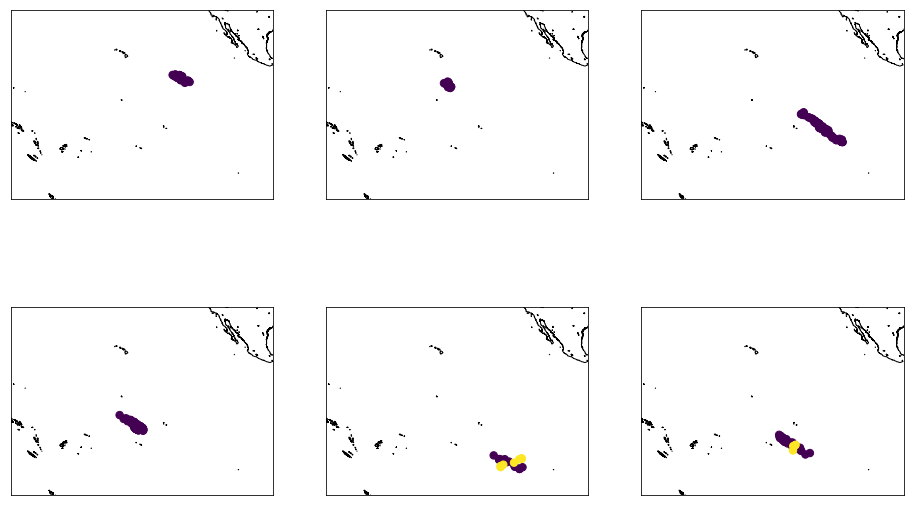

In [31]:
fig = plt.figure(figsize=(16,10))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    
    bbox = [np.min(Latitude),np.max(Latitude),
    np.min(Longitude)-25,np.max(Longitude)+25]

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
        llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    cmap = plt.get_cmap('viridis')

    # Draw coastlines and fill continents and water with color
    m.drawcoastlines()

    cluster = test[labels==i+6]
    x,y = m(cluster[:,1],cluster[:,0])
    timediff = cluster[:,2]-np.amin(cluster[:,2])
    print(np.max(timediff))
    color_interp = np.interp(timediff,[0,24],[0,200])
    ax.scatter(x,y,55,marker='o',c=cmap((color_interp)))
    

0.18252000212669373
92.71983337402344
9.755833333333612


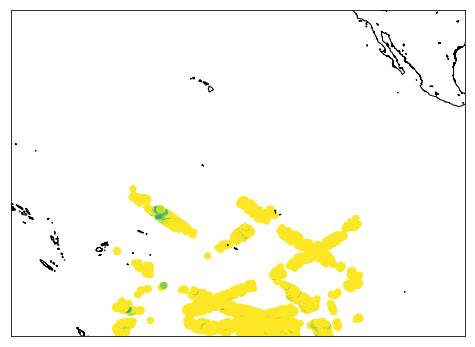

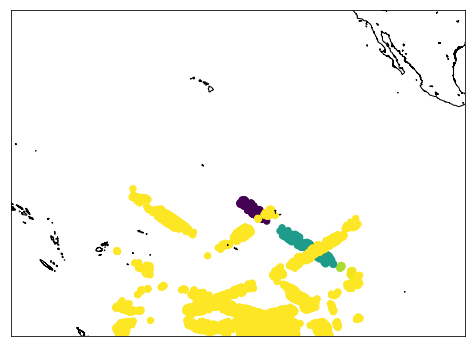

In [257]:
cluster = test[labels==80]
x,y = m(cluster[:,1]/2,cluster[:,0]/2)
timemin = np.amin(cluster[:,2])
timemax = np.amax(cluster[:,2])
Xdata = np.concatenate((Latitude.reshape(len(Latitude),1),Longitude.reshape(len(Longitude),1),DeltaTime.reshape(len(DeltaTime),1),SR.reshape(len(SR),1)),axis=1)
toplot = np.squeeze(Xdata[np.where(Xdata[:,2]>=timemin),:])
toplot = np.squeeze(toplot[np.where(toplot[:,2]<=timemax),:])

bbox = [np.min(Latitude),np.max(Latitude),
        np.min(Longitude)-25,np.max(Longitude)+25]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('viridis')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()

x,y = m(toplot[:,1],toplot[:,0])
timediff = toplot[:,2]-np.amin(toplot[:,2])
print(np.min(toplot[:,3]))
print(np.max(toplot[:,3]))
color_interp = np.interp(toplot[:,3],[0,65],[0,200])
plt.scatter(x,y,40,marker='o',color=cmap((color_interp)))

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('viridis')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()

x,y = m(toplot[:,1],toplot[:,0])
timediff = toplot[:,2]-np.amin(toplot[:,2])
print(np.max(timediff))
color_interp = np.interp(timediff,[0,24],[0,200])
plt.scatter(x,y,40,marker='o',color=cmap((color_interp)))

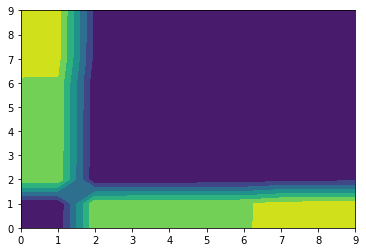

In [44]:
Rad_Earth = 6371 #km earth's radius
MesoScale = 200 #Mesoscale is up to a few hundred km'
FrontSpeed = 30 # km/h speed at which a front often moves

Scale_Time_to_Distance = FrontSpeed

#Distance = np.zeros((len(Data),len(Data)))
for i in range(len(Xdata[0:10,:])):
    for j in range(i,len(Xdata[0:10,:])):
        d = Rad_Earth*lat_long_to_arc(Xdata[i,0],Xdata[i,1],Xdata[j,0],Xdata[j,1])
        D = math.sqrt(d**2+(Scale_Time_to_Distance*(Xdata[i,2]-Xdata[j,2]))**2)
        Distance[i,j] = D
        Distance[j,i] = D

plt.contourf(Distance)

model = DBSCAN(eps=200, min_samples=2,metric='precomputed')
model.fit(Distance)

labels = model.labels_



In [45]:
print(labels)

[0 0 1 1 1 1 1 1 1 1]


In [48]:
import boto3
home = expanduser("~")

with open(os.path.join(home,'creds.json')) as creds_file:
    creds_data = json.load(creds_file)

#Access Spectogram from S3
s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
         aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
bucket = s3.Bucket('himatdata')
home = os.getcwd()
i = 0
for obj in bucket.objects.filter(Delimiter='', Prefix='Trmm/EPO/2000_01'):
    print(obj.key[17:])
    bucket.download_file(obj.key,os.path.join(os.path.join(home,'S3_downloads/',obj.key[17:])))
    L, S, A, la, lo, Ti = extract_data(xr.open_dataset(os.path.join(home,'S3_downloads/',obj.key[17:])),0)
    os.remove(os.path.join(home,'S3_downloads/',obj.key[17:]))
    break
    

TPR7_uw1_12050.20000101.003738_EPO.nc4


In [54]:
Data, Time, A = load_s3_data(5)

TPR7_uw1_12050.20000101.003738_EPO.nc4
TPR7_uw1_12050.20000101.004024_EPO.nc4
TPR7_uw1_12050.20000101.004113_EPO.nc4
TPR7_uw1_12050.20000101.004234_EPO.nc4
TPR7_uw1_12050.20000101.004721_EPO.nc4
TPR7_uw1_12051.20000101.021333_EPO.nc4


labels = model.labels_
d = {'lat': Latitude, 'lon': Longitude, 'label': labels}
d = pd.DataFrame(data=d)
df = d.groupby(d.columns.tolist(),as_index=False).size()
axes = np.array(df.axes)
values = np.array(df.values)
print(np.array(df.axes))
print(np.array(df.values))
